In [79]:
import pandas as pd
from tqdm import tqdm
import numpy as np

In [80]:
### read in results
hpv_positive_direct_results = pd.read_csv('Results/HPV Positive direct results.csv')
hpv_negative_direct_results = pd.read_csv('Results/HPV Negative direct results.csv')

### genes
hpv_positive_genes  = pd.read_csv('Results/HPV positive gene results.csv')
hpv_negative_genes = pd.read_csv('Results/HPV negative gene results.csv')


### DrugBank Data

In [81]:
# import xml.etree.ElementTree as ET

# # Load XML
# drugbank_xml = 'Data/DGIDB/drug_bank.xml'
# tree = ET.parse(drugbank_xml)
# root = tree.getroot()

# # Namespace
# ns = {'db': 'http://www.drugbank.ca'}

# Helper to clean tag names
def clean_tag(tag):
    return tag.split('}')[-1] if '}' in tag else tag

# Recursive function to print structure
def print_structure(elem, level=0):
    indent = '  ' * level
    print(f"{indent}- {clean_tag(elem.tag)}")
    for child in elem:
        print_structure(child, level + 1)

# # Get first drug
# first_drug = root.find('db:drug', ns)

# print("🌿 Structure of First Drug Entry:")
# print_structure(first_drug)
# print("\n🌳 Structure of First 3 Drug Entries:")
# drugs = root.findall('db:drug', ns)

# for i, drug in enumerate(drugs[:3]):
#     print(f"\n🔬 Drug {i+1}:")
#     print_structure(drug)


In [82]:
def structure_drug_bank_data(drug_bank_file = 'Data/DGIDB/drug_bank.xml'):
    """
    Function to structure the drug bank data from the XML file.
    :param drug_bank_file: Path to the drug bank XML file.
    :return: DataFrame containing structured drug bank data.
    """
    ### FYI the .find command only finds the first instance of a tag, 
    ### while .findall retrieves all instances of the specified tag within the current element.

    tree = ET.parse(drug_bank_file)
    root = tree.getroot()

    # DrugBank uses a specific namespace
    ns = {'db': 'http://www.drugbank.ca'}
    ### extract all drug elements
    drugs = root.findall('db:drug', ns)
    print(f"Found {len(drugs)} drugs in the DrugBank XML.")
    # Extract drug-gene interactions
    interactions = []
    # The interactions list will store dictionaries with 'drug' and 'gene' keys.
    for drug in root.findall('db:drug', ns): # root.findall('db:drug', ns): Finds all <drug> elements using the namespace.
        drug_name  = drug.find('db:name', ns).text  # drug.find('db:name', ns): Gets the drug's name.
        # print(drug_name)
        for target in drug.findall('db:targets/db:target', ns):  # drug.findall('db:targets/db:target', ns): Finds all <target> elements within <targets>.
            # print(target.tag)
            gene_description = target.find('db:name', ns)  # target.find('db:name', ns): Extracts the gene name for each target.
            poly = target.find('db:polypeptide', ns)  # target.find('db:polypeptide', ns): Extracts the polypeptide information.
            action = target.find('db:actions/db:action', ns) # target.find('db:actions/db:action', ns): Extracts the action of the drug on the target.
            if poly is not None:
                poly_name = poly.find('db:name', ns)
                gene_name = poly.find('db:gene-name', ns)
                specific_function = poly.find('db:specific-function', ns)
                interactions.append({
                    'drug': drug_name,
                    'polypeptide': poly_name.text if poly_name is not None else None,
                    'gene': gene_name.text if gene_name is not None else None,
                    'gene_description': gene_description.text if gene_description is not None else None,
                    'action': action.text if action is not None else None,
                    'specific_function': specific_function.text if specific_function is not None else None
                })
            ############# if polypeptide is not present, we still want to add the drug and gene information
            ############# this is because some drugs may not have a polypeptide associated with them
            ############# but we still want to capture the drug and gene information
            ############# this is common in the DrugBank database, where some drugs target genes directly
            ############# and do not have a polypeptide associated with them

            else:
                gene_name = None
                specific_function = None
                poly_name = None
                action = None
                gene_description = None
                resource = None
                identifier = None
  
                interactions.append({
                        'drug': drug_name,
                        'polypeptide': poly_name.text if poly_name is not None else None,
                        'gene': gene_name.text if gene_name is not None else None,
                        'gene_description': gene_description.text if gene_description is not None else None,
                        'action': action.text if action is not None else None,
                        'specific_function': specific_function.text if specific_function is not None else None
                    })
        
    # Convert to DataFrame
    # Converts the list of dictionaries into a pandas DataFrame, which is easier to analyze, filter, and export.
    df = pd.DataFrame(interactions)

    return df

In [83]:
Drug_bank = structure_drug_bank_data('Data/DGIDB/drug_bank.xml')

Found 17430 drugs in the DrugBank XML.


In [84]:
Drug_bank

,drug,polypeptide,gene,gene_description,action,specific_function
0,Lepirudin,Prothrombin,F2,Prothrombin,inhibitor,calcium ion binding
1,Cetuximab,Epidermal growth factor receptor,EGFR,Epidermal growth factor receptor,binder,actin filament binding
2,Cetuximab,Low affinity immunoglobulin gamma Fc region re...,FCGR3B,Low affinity immunoglobulin gamma Fc region re...,binder,GPI anchor binding
3,Cetuximab,Complement C1q subcomponent subunit A,C1QA,Complement C1q subcomponent subunit A,binder,amyloid-beta binding
4,Cetuximab,Complement C1q subcomponent subunit B,C1QB,Complement C1q subcomponent subunit B,binder,None
...,...,...,...,...,...,...
23131,Benzgalantamine,Muscle nicotinic acetylcholine receptor,None,Muscle nicotinic acetylcholine receptor,allosteric modulator,extracellular ligand-gated monoatomic ion chan...
23132,Zoxazolamine,Small conductance calcium-activated potassium ...,KCNN2,Small conductance calcium-activated potassium ...,activator,alpha-actinin binding
23133,Megestrol,Progesterone receptor,PGR,Progesterone receptor,binder,ATPase binding
23134,AZACYCLONOL,Histamine H1 receptor,HRH1,Histamine H1 receptor,inhibitor,G protein-coupled serotonin receptor activity


In [85]:
hpv_positive_direct_results

,Unnamed: 0,DRUG,GENE_TARGET,MUT_TYPE,NUM_DIRECT_TARGETS_HIT,TOTAL_TARGETS_IN_DRUGBANK,PERCENTAGE_OF_TARGETS_HIT,ACTION,SPECIFIC_FUNCTION,drug_hypergeom_p_value,drug_hypergeom_fdr,drug_empirical_p_value,drug_empirical_fdr,PMID,NUMBER_OF_ARTICLES,LITERATURE_GENE_TARGETS
0,0,Buparlisib,"PIK3CA, PIK3CA","AMPLIFICATION, SOMATIC",1,4,25.0,inhibitor,1-phosphatidylinositol-3-kinase activity,0.000517,0.034338,0.00049,0.038574,"14581353, 18447972, 16380997, 16807070, 179903...",34,PIK3CA
1,1,CH-5132799,"PIK3CA, PIK3CA","AMPLIFICATION, SOMATIC",1,4,25.0,inhibitor,1-phosphatidylinositol-3-kinase activity,0.000517,0.034338,0.00049,0.038574,"14581353, 18447972, 16380997, 16807070, 179903...",34,PIK3CA
2,3,Copanlisib,"PIK3CA, PIK3CA","AMPLIFICATION, SOMATIC",1,4,25.0,inhibitor,1-phosphatidylinositol-3-kinase activity,0.000517,0.034338,0.00049,0.038574,"14581353, 18447972, 16380997, 16807070, 179903...",34,PIK3CA
3,5,Golotimod,TLR7,DELETION,1,5,20.0,NaN,double-stranded RNA binding,0.000016,0.006539,0.00001,0.005204,17201162,1,TLR7
4,8,Wortmannin,PIK3CA,SOMATIC,1,5,20.0,NaN,1-phosphatidylinositol-3-kinase activity,0.000003,0.000413,0.00010,0.011423,"14581353, 18447972, 16380997, 16807070, 179903...",17,PIK3CA
5,9,XL765,"PIK3CA, PIK3CA","AMPLIFICATION, SOMATIC",1,5,20.0,NaN,1-phosphatidylinositol-3-kinase activity,0.000078,0.008661,0.00009,0.011152,"14581353, 18447972, 16380997, 16807070, 179903...",34,PIK3CA


### HPV+

In [86]:
hpv_positive_genes.sort_values(by = ['q_value', 'empirical_q_value'], ascending=[True,True]).head(50)

,Unnamed: 0,gene_name,MUT_TYPE,q_value,empirical_q_value
37,37,SOX2,AMPLIFICATION,9.686950e-39,0.011719
38,38,SST,AMPLIFICATION,9.686950e-39,0.011719
19,19,MASP1,AMPLIFICATION,4.671222e-38,0.011719
27,27,PIK3CA,"AMPLIFICATION, SOMATIC",1.166147e-37,0.000000
1,1,ACTL6A,AMPLIFICATION,1.166147e-37,0.011719
2,2,ADIPOQ,AMPLIFICATION,1.166147e-37,0.011719
3,3,AHSG,AMPLIFICATION,1.166147e-37,0.011719
8,8,DNAJB11,AMPLIFICATION,1.166147e-37,0.011719
10,10,EIF4A2,AMPLIFICATION,1.166147e-37,0.011719
11,11,FXR1,AMPLIFICATION,1.166147e-37,0.011719


In [87]:
### show hpv positive direct results only literature validated, show only literature validated genes, mut type, pmid, NUMBER_OF_ARTICLES, drug, gene, drug_empirical_fdr
hpv_positive_direct_results = hpv_positive_direct_results.rename(columns={'LITERATURE_GENE_TARGETS': 'LITERATURE_VALIDATED_GENE_TARGETS'})
hpv_positive_direct_results[['DRUG', 'LITERATURE_VALIDATED_GENE_TARGETS', 'MUT_TYPE', 'PMID', 'NUMBER_OF_ARTICLES', 'drug_empirical_fdr']][hpv_positive_direct_results['NUMBER_OF_ARTICLES']>0].sort_values(by='drug_empirical_fdr').head(20)


,DRUG,LITERATURE_VALIDATED_GENE_TARGETS,MUT_TYPE,PMID,NUMBER_OF_ARTICLES,drug_empirical_fdr
3,Golotimod,TLR7,DELETION,17201162,1,0.005204
5,XL765,PIK3CA,"AMPLIFICATION, SOMATIC","14581353, 18447972, 16380997, 16807070, 179903...",34,0.011152
4,Wortmannin,PIK3CA,SOMATIC,"14581353, 18447972, 16380997, 16807070, 179903...",17,0.011423
0,Buparlisib,PIK3CA,"AMPLIFICATION, SOMATIC","14581353, 18447972, 16380997, 16807070, 179903...",34,0.038574
1,CH-5132799,PIK3CA,"AMPLIFICATION, SOMATIC","14581353, 18447972, 16380997, 16807070, 179903...",34,0.038574
2,Copanlisib,PIK3CA,"AMPLIFICATION, SOMATIC","14581353, 18447972, 16380997, 16807070, 179903...",34,0.038574


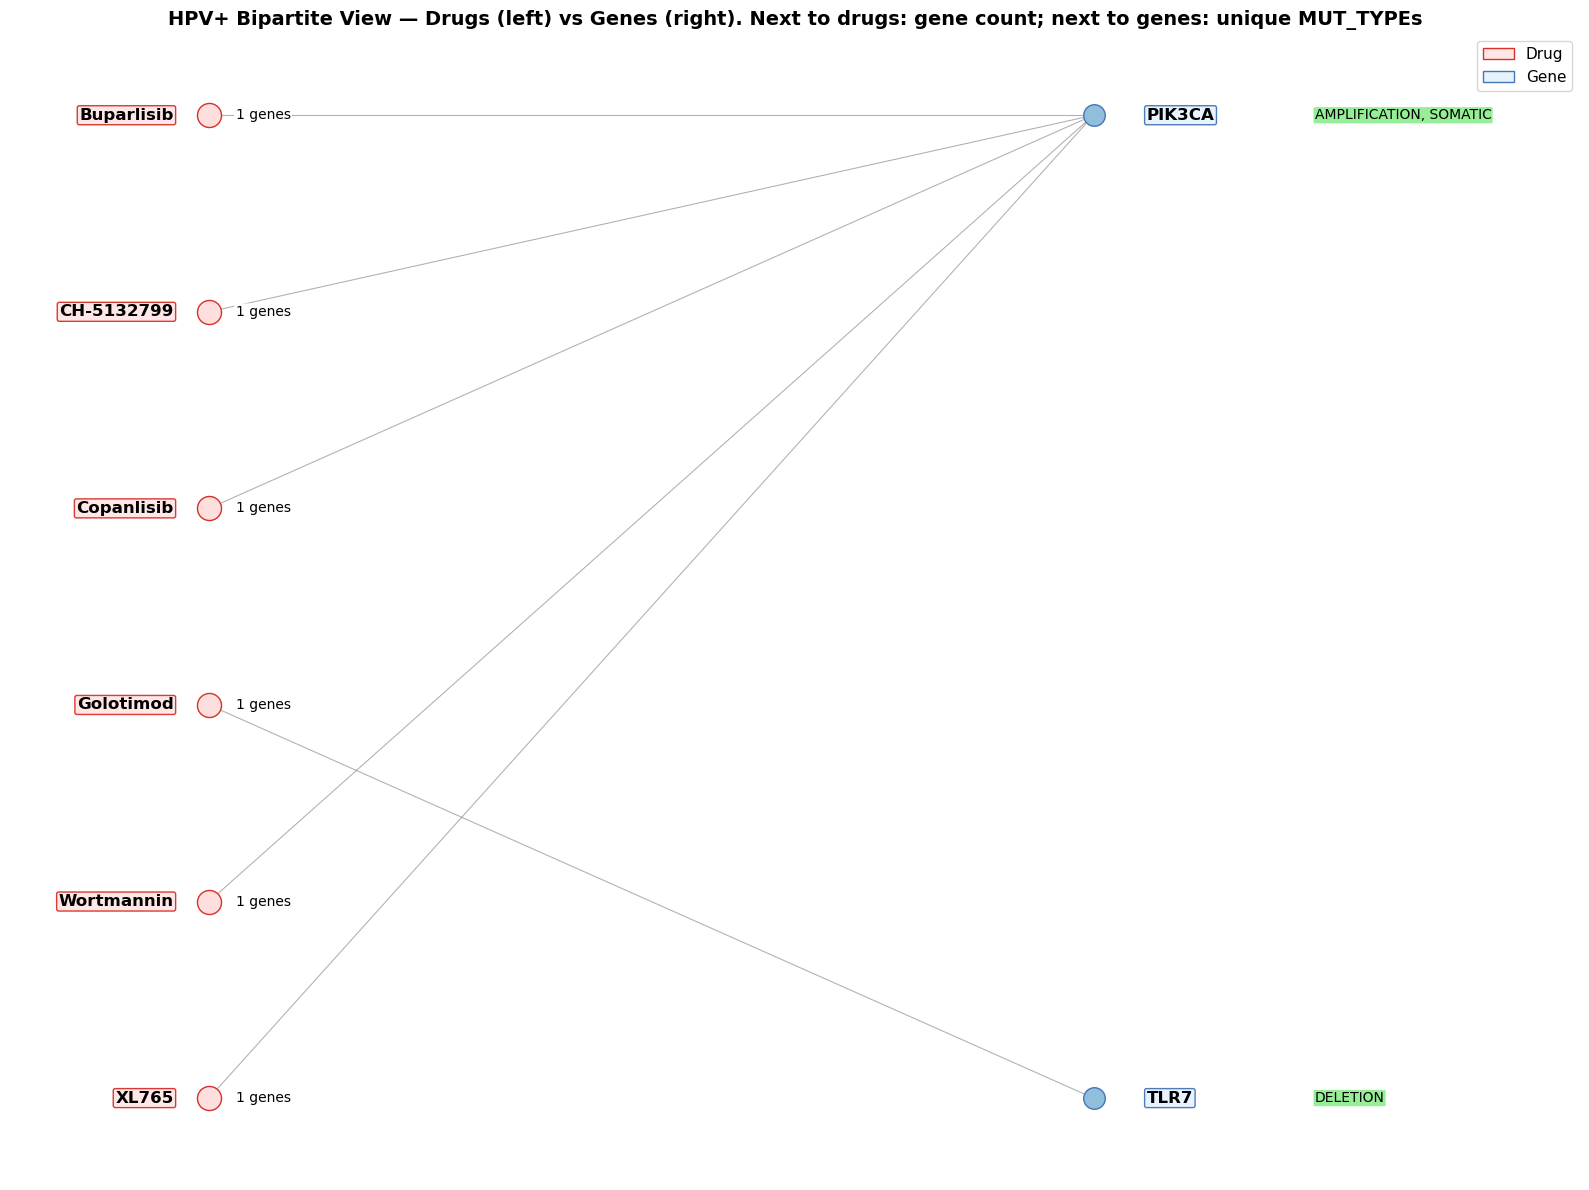


Network Statistics:
Total drugs: 6
Total genes: 2
Total connections: 6

Top 5 drugs by number of genes:
  Buparlisib: 1 genes
  CH-5132799: 1 genes
  Copanlisib: 1 genes
  Golotimod: 1 genes
  Wortmannin: 1 genes

All gene unique mutation types (normalized):
  PIK3CA: AMPLIFICATION, SOMATIC
  TLR7: DELETION


In [88]:
# Cell 23: Bipartite layout — drugs left, genes right; show per-drug gene count and gene mutation types

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd

def parse_genes(field):
    if pd.isna(field):
        return []
    return [g.strip() for g in str(field).split(',') if g.strip()]

# Build graph
G = nx.Graph()
for _, row in hpv_positive_direct_results.iterrows():
    drug = row['DRUG']
    genes = parse_genes(row['GENE_TARGET'])
    if not G.has_node(drug):
        G.add_node(drug, type='drug')
    for gene in genes:
        if not G.has_node(gene):
            G.add_node(gene, type='gene')
        G.add_edge(drug, gene)

# Prepare lists - sort drugs by degree (number of genes targeted), descending
deg_map_temp = dict(G.degree())
drug_nodes = sorted([n for n,d in G.nodes(data=True) if d.get('type')=='drug'], 
                     key=lambda x: -deg_map_temp.get(x, 0))
gene_nodes = sorted([n for n,d in G.nodes(data=True) if d.get('type')=='gene'])

# simple bipartite positions
left_x, right_x = -1.0, 1.0
# space y positions between -0.9 .. 0.9
if drug_nodes:
    y_drugs = np.linspace(0.9, -0.9, len(drug_nodes))
else:
    y_drugs = []
if gene_nodes:
    y_genes = np.linspace(0.9, -0.9, len(gene_nodes))
else:
    y_genes = []

pos = {}
for i,d in enumerate(drug_nodes):
    pos[d] = np.array([left_x, y_drugs[i]])
for i,g in enumerate(gene_nodes):
    pos[g] = np.array([right_x, y_genes[i]])

# compute degree counts and mutation types (unique per gene)
deg_map = dict(G.degree())

# Helper to normalize mutation types and handle truncations/variations
def normalize_mut_type(mut_str):
    """Normalize mutation type and handle common variations/truncations"""
    mut_str = mut_str.strip().upper()
    # Handle truncated versions (e.g., "S..." means SOMATIC)
    if mut_str.startswith('S') and '...' in mut_str:
        return 'SOMATIC'
    # Remove any trailing "..." artifacts
    mut_str = mut_str.replace('...', '')
    return mut_str

# Collect mutation types from hpv_positive_genes (genes may appear multiple times with different mutation types)
gene_mut = {}
for _, r in hpv_positive_genes.iterrows():
    gene = r.get('gene_name', '').strip()
    mut = r.get('MUT_TYPE', '') or ''
    if gene:
        gene_mut.setdefault(gene, set())
        if mut:
            # split by comma and deduplicate with normalization
            for t in str(mut).split(','):
                t_clean = normalize_mut_type(t)
                if t_clean:
                    gene_mut[gene].add(t_clean)

# small helper to wrap mutation text into lines (~max_chars per line)
def wrap_mut_text(mut_txt, max_chars=40):
    parts = [p.strip() for p in mut_txt.split(',') if p.strip()]
    if not parts:
        return ''
    lines = []
    cur = ''
    for p in parts:
        if cur == '':
            cur = p
        elif len(cur) + 2 + len(p) <= max_chars:
            cur = cur + ', ' + p
        else:
            lines.append(cur)
            cur = p
    if cur:
        lines.append(cur)
    return '\n'.join(lines)

# drawing
fig, ax = plt.subplots(figsize=(16, 12))

# draw edges
for u,v in G.edges():
    x1,y1 = pos[u]
    x2,y2 = pos[v]
    ax.plot([x1,x2],[y1,y2], color='gray', linewidth=0.8, alpha=0.6, zorder=1)

# draw nodes
for d in drug_nodes:
    x,y = pos[d]
    ax.scatter([x],[y], s=300, color='#ffdede', edgecolor='#d73027', zorder=3)
for g in gene_nodes:
    x,y = pos[g]
    ax.scatter([x],[y], s=240, color='#91bfdb', edgecolor='#4575b4', zorder=3)

# labels and small info boxes
for d in drug_nodes:
    x,y = pos[d]
    # drug label
    ax.text(x - 0.08, y, d, ha='right', va='center', fontsize=12, fontweight='bold', zorder=4,
            bbox=dict(boxstyle='round,pad=0.12', facecolor='#ffe6e6', edgecolor='#d73027', linewidth=1.0, alpha=0.95))
    # gene count box just to the right of the drug label
    count = sum(1 for nbr in G.neighbors(d))
    ax.text(x + 0.06, y, f"{count} genes", ha='left', va='center', fontsize=10, color='black', zorder=4,
            bbox=dict(boxstyle='round,pad=0.10', facecolor='white', edgecolor='none', alpha=0.95))

# gene labels and mutation types: place mutation box inline (same y) and well to the right
label_font = 12
mut_font = 10
for g in gene_nodes:
    x,y = pos[g]
    # move gene label slightly right
    label_x = x + 0.12

    # prepare mutation text (unique, sorted, upper-case, normalized)
    muts = sorted(list(gene_mut.get(g, [])))
    mut_txt = ', '.join(muts) if muts else ''
    if mut_txt:
        mut_txt_wrapped = wrap_mut_text(mut_txt, max_chars=36)
    else:
        mut_txt_wrapped = ''

    # place label
    ax.text(label_x, y, g, ha='left', va='center', fontsize=label_font, fontweight='bold', zorder=4,
            bbox=dict(boxstyle='round,pad=0.12', facecolor='#e6f3ff', edgecolor='#4575b4', linewidth=1.0, alpha=0.95))

    # place mutation box inline (same y, not offset downward) with safe horizontal offset
    if mut_txt_wrapped:
        mut_x = x + 0.50  # pushed further right
        ax.text(mut_x, y, mut_txt_wrapped, ha='left', va='center', fontsize=mut_font, color='black', zorder=4,
                bbox=dict(boxstyle='round,pad=0.08', facecolor='lightgreen', edgecolor='none', alpha=0.95))

# legend-like handles
import matplotlib.patches as mpatches
handles = [
    mpatches.Rectangle((0,0),1,1, facecolor='#ffe6e6', edgecolor='#d73027', linewidth=1.0, label='Drug'),
    mpatches.Rectangle((0,0),1,1, facecolor='#e6f3ff', edgecolor='#4575b4', linewidth=1.0, label='Gene'),
]
ax.legend(handles=handles, loc='upper right', fontsize=11)

ax.set_title('HPV+ Bipartite View — Drugs (left) vs Genes (right). Next to drugs: gene count; next to genes: unique MUT_TYPEs', fontsize=14, fontweight='bold')
ax.set_xlim(-1.45, 2.1)
ax.set_ylim(-1.05, 1.05)
ax.axis('off')
plt.tight_layout()
plt.show()

# print stats
print('\nNetwork Statistics:')
print(f"Total drugs: {len(drug_nodes)}")
print(f"Total genes: {len(gene_nodes)}")
print(f"Total connections: {G.number_of_edges()}")

print('\nTop 5 drugs by number of genes:')
for d in sorted(drug_nodes, key=lambda x: -deg_map.get(x,0))[:5]:
    print(f"  {d}: {deg_map.get(d,0)} genes")

print('\nAll gene unique mutation types (normalized):')
for g in sorted(gene_nodes):
    muts_disp = ', '.join(sorted(gene_mut.get(g, []))) if gene_mut.get(g) else 'None'
    print(f"  {g}: {muts_disp}")

In [89]:
# Check the structure of the data and available columns
print("Columns in hpv_positive_direct_results:")
print(hpv_positive_direct_results.columns.tolist())
print("\nSample of the data:")
print(hpv_positive_direct_results.head())

# Check if MUT_type column exists and what values it contains
if 'MUT_type' in hpv_positive_direct_results.columns:
    print("\nUnique mutation types:")
    print(hpv_positive_direct_results['MUT_type'].value_counts())
    print("\nSample rows with MUT_type:")
    print(hpv_positive_direct_results[['GENE_TARGET', 'MUT_type']].head(10))
else:
    print("\nMUT_type column not found in the dataframe")

Columns in hpv_positive_direct_results:
['Unnamed: 0', 'DRUG', 'GENE_TARGET', 'MUT_TYPE', 'NUM_DIRECT_TARGETS_HIT', 'TOTAL_TARGETS_IN_DRUGBANK', 'PERCENTAGE_OF_TARGETS_HIT', 'ACTION', 'SPECIFIC_FUNCTION', 'drug_hypergeom_p_value', 'drug_hypergeom_fdr', 'drug_empirical_p_value', 'drug_empirical_fdr', 'PMID', 'NUMBER_OF_ARTICLES', 'LITERATURE_VALIDATED_GENE_TARGETS']

Sample of the data:
   Unnamed: 0        DRUG     GENE_TARGET                MUT_TYPE  \
0           0  Buparlisib  PIK3CA, PIK3CA  AMPLIFICATION, SOMATIC   
1           1  CH-5132799  PIK3CA, PIK3CA  AMPLIFICATION, SOMATIC   
2           3  Copanlisib  PIK3CA, PIK3CA  AMPLIFICATION, SOMATIC   
3           5   Golotimod            TLR7                DELETION   
4           8  Wortmannin          PIK3CA                 SOMATIC   

   NUM_DIRECT_TARGETS_HIT  TOTAL_TARGETS_IN_DRUGBANK  \
0                       1                          4   
1                       1                          4   
2                       1   

In [90]:
# Check MUT_TYPE column (uppercase)
print("Unique mutation types in MUT_TYPE:")
print(hpv_positive_direct_results['MUT_TYPE'].value_counts())

print("\nSample of genes with their mutation types:")
gene_mut_sample = hpv_positive_direct_results[['DRUG', 'GENE_TARGET', 'MUT_TYPE']].drop_duplicates()
print(gene_mut_sample)

# Let's see what genes have multiple mutation types
print("\nGenes that appear with different mutation types:")
gene_mut_types = hpv_positive_direct_results.groupby('GENE_TARGET')['MUT_TYPE'].unique()
for gene, mut_types in gene_mut_types.items():
    if len(mut_types) > 1:
        print(f"{gene}: {list(mut_types)}")
        

Unique mutation types in MUT_TYPE:
MUT_TYPE
AMPLIFICATION, SOMATIC    4
DELETION                  1
SOMATIC                   1
Name: count, dtype: int64

Sample of genes with their mutation types:
         DRUG     GENE_TARGET                MUT_TYPE
0  Buparlisib  PIK3CA, PIK3CA  AMPLIFICATION, SOMATIC
1  CH-5132799  PIK3CA, PIK3CA  AMPLIFICATION, SOMATIC
2  Copanlisib  PIK3CA, PIK3CA  AMPLIFICATION, SOMATIC
3   Golotimod            TLR7                DELETION
4  Wortmannin          PIK3CA                 SOMATIC
5       XL765  PIK3CA, PIK3CA  AMPLIFICATION, SOMATIC

Genes that appear with different mutation types:


### HPV- 

Distribution of q_values in hpv_negative_genes:
Total genes: 407
Min q_value: 0.00e+00
Max q_value: 3.41e-02
Median q_value: 8.33e-06
Mean q_value: 5.62e-03


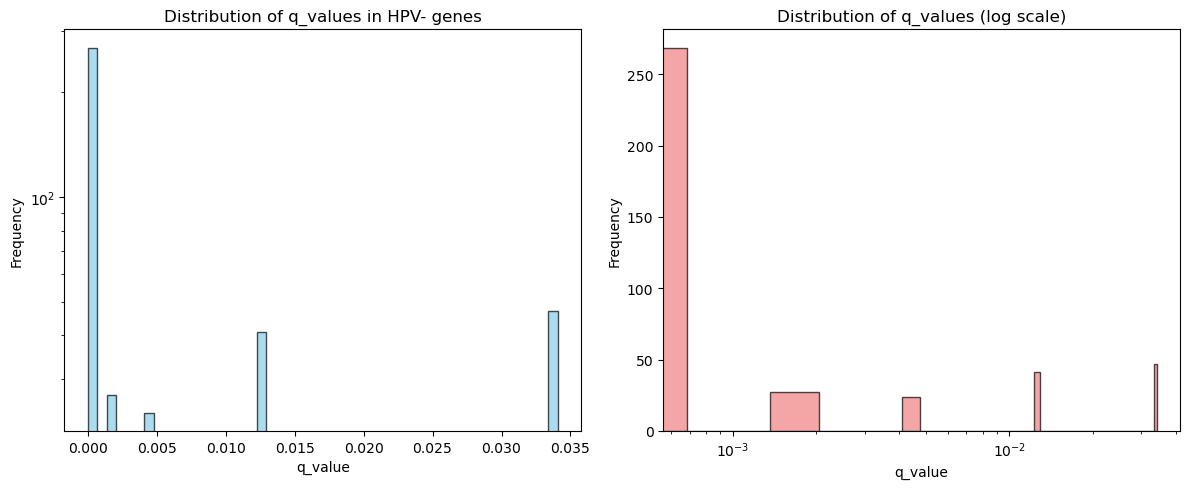


Genes by significance levels:
q_value < 0.001: 268
q_value < 0.01: 319
q_value < 0.05: 407


In [91]:
print("Distribution of q_values in hpv_negative_genes:")
print(f"Total genes: {len(hpv_negative_genes)}")
print(f"Min q_value: {hpv_negative_genes['q_value'].min():.2e}")
print(f"Max q_value: {hpv_negative_genes['q_value'].max():.2e}")
print(f"Median q_value: {hpv_negative_genes['q_value'].median():.2e}")
print(f"Mean q_value: {hpv_negative_genes['q_value'].mean():.2e}")

# Show distribution by bins
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram of q_values
ax1.hist(hpv_negative_genes['q_value'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_xlabel('q_value')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of q_values in HPV- genes')
ax1.set_yscale('log')

# Log-scale histogram for better visualization
ax2.hist(hpv_negative_genes['q_value'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
ax2.set_xlabel('q_value')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of q_values (log scale)')
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

# Count genes by significance levels
print("\nGenes by significance levels:")
print(f"q_value < 0.001: {(hpv_negative_genes['q_value'] < 0.001).sum()}")
print(f"q_value < 0.01: {(hpv_negative_genes['q_value'] < 0.01).sum()}")
print(f"q_value < 0.05: {(hpv_negative_genes['q_value'] < 0.05).sum()}")



In [92]:
hpv_negative_genes.sort_values(by = ['q_value', 'empirical_q_value'], ascending=[True,True]).head(50)

,Unnamed: 0,gene_name,MUT_TYPE,q_value,empirical_q_value
246,246,NLGN1,"AMPLIFICATION, SOMATIC",0.0,0.000000
284,284,PIK3CA,"AMPLIFICATION, SOMATIC",0.0,0.000000
290,290,PLD1,"AMPLIFICATION, SOMATIC",0.0,0.000000
371,371,TP53,SOMATIC,0.0,0.000000
1,1,ACTL6A,AMPLIFICATION,0.0,0.003858
9,9,ADIPOQ,AMPLIFICATION,0.0,0.003858
13,13,AHSG,AMPLIFICATION,0.0,0.003858
21,21,AP2M1,AMPLIFICATION,0.0,0.003858
29,29,BCHE,AMPLIFICATION,0.0,0.003858
30,30,BCL6,AMPLIFICATION,0.0,0.003858


In [93]:
hpv_negative_direct_results

,Unnamed: 0,DRUG,GENE_TARGET,MUT_TYPE,NUM_DIRECT_TARGETS_HIT,TOTAL_TARGETS_IN_DRUGBANK,PERCENTAGE_OF_TARGETS_HIT,ACTION,SPECIFIC_FUNCTION,drug_hypergeom_p_value,drug_hypergeom_fdr,drug_empirical_p_value,drug_empirical_fdr,PMID,NUMBER_OF_ARTICLES,LITERATURE_GENE_TARGETS
0,0,Acetylsalicylic acid,TP53,SOMATIC,1,20,5.000000,inducer,14-3-3 protein binding,1.159980e-05,4.179498e-03,0.00010,0.023418,"12935924, 12673679, 16012721, 11916556, 176380...",29,TP53
1,1,Anti-inhibitor coagulant complex,"F5, FGA","SOMATIC, SOMATIC",2,8,25.000000,agonist,copper ion binding,1.001586e-04,1.996353e-02,0.00010,0.023418,15631354,1,FGA
2,2,"Antihemophilic factor, human recombinant","VWF, LRP1","SOMATIC, SOMATIC",2,11,18.181818,binder,collagen binding,7.822418e-05,1.704196e-02,0.00010,0.023418,12030606,1,VWF
3,4,Bisindolylmaleimide I,"PRKCI, ROCK1","AMPLIFICATION, SOMATIC",1,19,5.263158,inhibitor,ATP binding,1.278605e-07,7.985313e-05,0.00001,0.002755,17990328,1,PRKCI
4,5,Brigatinib,ERBB4,SOMATIC,1,9,11.111111,inhibitor,ATP binding,3.160485e-05,8.459264e-03,0.00010,0.023418,"17969526, 17604679, 11673832, 18043285, 15476268",5,ERBB4
5,6,Bryostatin 1,"CASP8, PRKD1","SOMATIC, SOMATIC",2,9,22.222222,inhibitor,cysteine-type endopeptidase activity,3.160485e-05,8.459264e-03,0.00010,0.023418,16857411,1,CASP8
6,9,Dasatinib,"EPHA2, EPHA5","SOMATIC, SOMATIC",2,23,8.695652,antagonist,ATP binding,3.754102e-05,9.769008e-03,0.00010,0.023418,"18030354, 18425361, 12494475, 16309192, 18485799",5,EPHA2
7,13,Fostamatinib,"PRKCI, TNIK, MAP3K13, EPHA7, MYO3A, EPHA2, EPH...","AMPLIFICATION, AMPLIFICATION, AMPLIFICATION, S...",3,300,1.000000,inhibitor,ATP binding,1.720246e-09,2.014408e-06,0.00001,0.002755,"17990328, 18030354, 17969526, 18425361, 124944...",11,"EPHA2, ERBB4, PRKCI"
8,15,Heparin,SELP,SOMATIC,1,12,8.333333,inhibitor,calcium ion binding,9.898833e-07,6.086135e-04,0.00010,0.023418,16135921,1,SELP
9,16,Human thrombin,"F5, FGA","SOMATIC, SOMATIC",2,8,25.000000,activator,copper ion binding,1.001586e-04,1.996353e-02,0.00010,0.023418,15631354,1,FGA


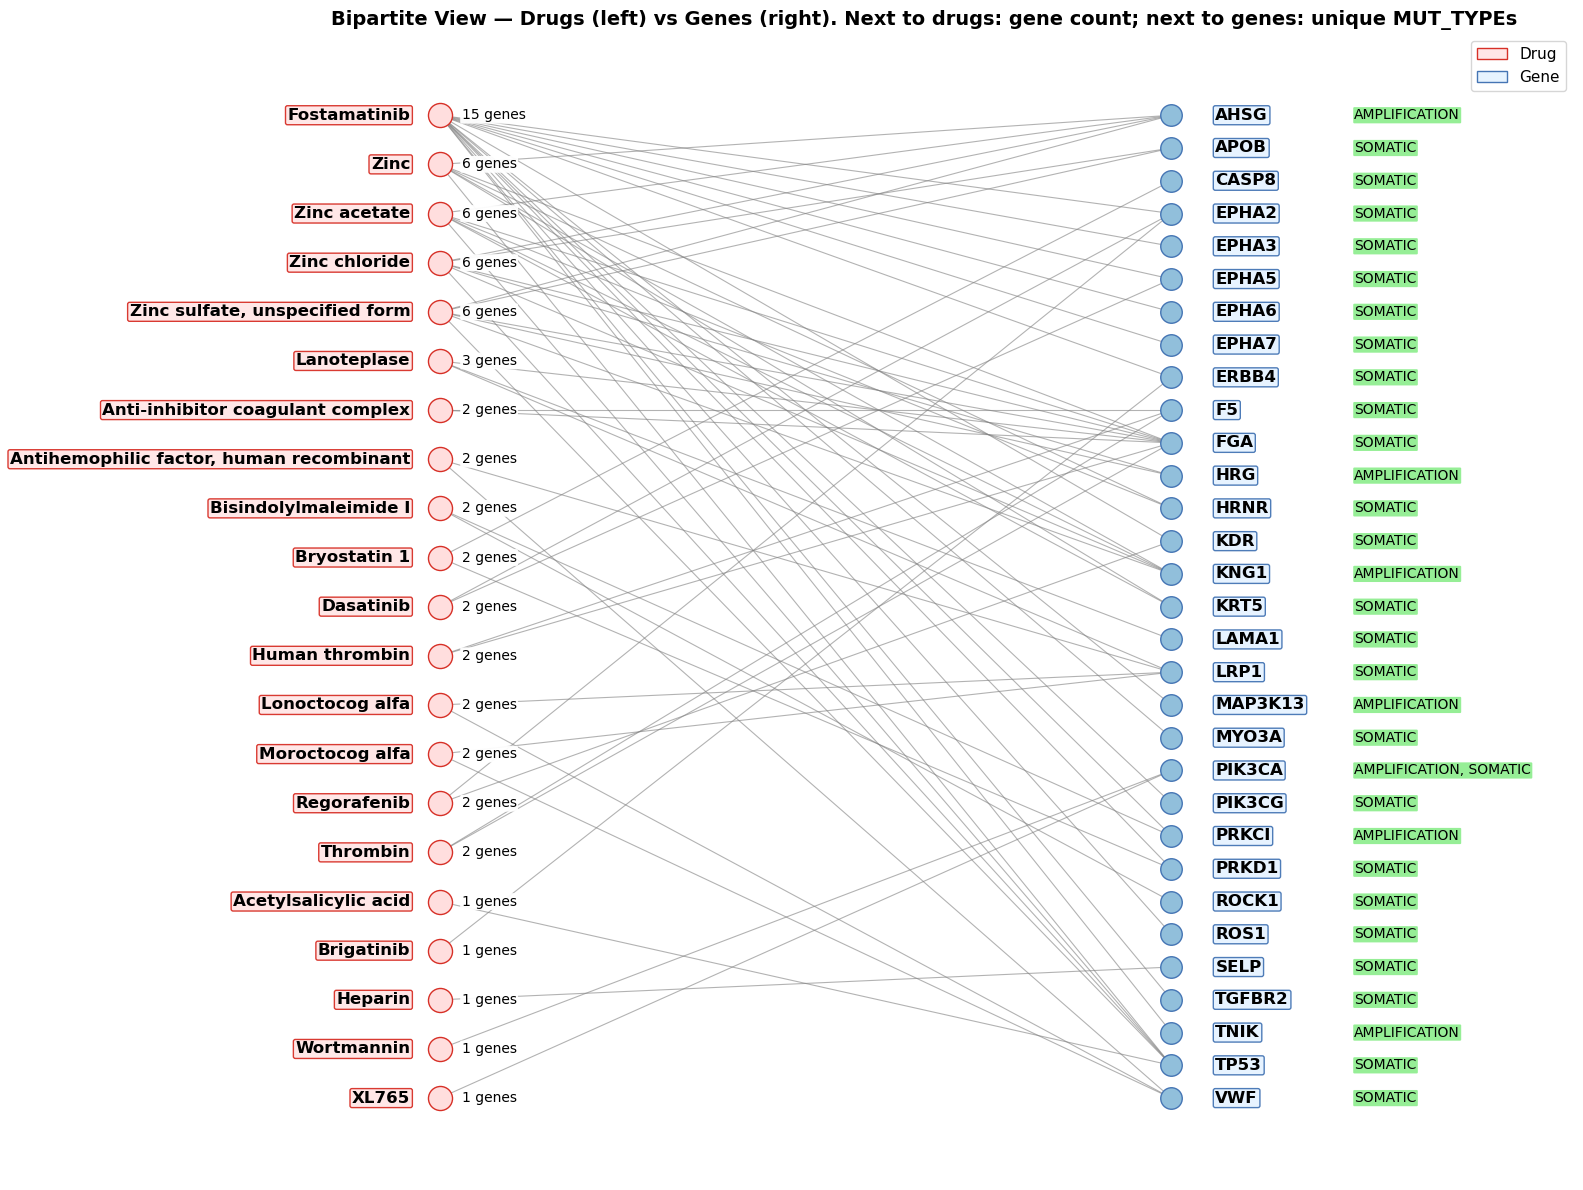


Network Statistics:
Total drugs: 21
Total genes: 31
Total connections: 67

Top 5 drugs by number of genes:
  Fostamatinib: 15 genes
  Zinc: 6 genes
  Zinc acetate: 6 genes
  Zinc chloride: 6 genes
  Zinc sulfate, unspecified form: 6 genes

All gene unique mutation types (normalized):
  AHSG: AMPLIFICATION
  APOB: SOMATIC
  CASP8: SOMATIC
  EPHA2: SOMATIC
  EPHA3: SOMATIC
  EPHA5: SOMATIC
  EPHA6: SOMATIC
  EPHA7: SOMATIC
  ERBB4: SOMATIC
  F5: SOMATIC
  FGA: SOMATIC
  HRG: AMPLIFICATION
  HRNR: SOMATIC
  KDR: SOMATIC
  KNG1: AMPLIFICATION
  KRT5: SOMATIC
  LAMA1: SOMATIC
  LRP1: SOMATIC
  MAP3K13: AMPLIFICATION
  MYO3A: SOMATIC
  PIK3CA: AMPLIFICATION, SOMATIC
  PIK3CG: SOMATIC
  PRKCI: AMPLIFICATION
  PRKD1: SOMATIC
  ROCK1: SOMATIC
  ROS1: SOMATIC
  SELP: SOMATIC
  TGFBR2: SOMATIC
  TNIK: AMPLIFICATION
  TP53: SOMATIC
  VWF: SOMATIC


In [94]:
# Cell 23: Bipartite layout — drugs left, genes right; show per-drug gene count and gene mutation types

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd

def parse_genes(field):
    if pd.isna(field):
        return []
    return [g.strip() for g in str(field).split(',') if g.strip()]

# Build graph
G = nx.Graph()
for _, row in hpv_negative_direct_results.iterrows():
    drug = row['DRUG']
    genes = parse_genes(row['GENE_TARGET'])
    if not G.has_node(drug):
        G.add_node(drug, type='drug')
    for gene in genes:
        if not G.has_node(gene):
            G.add_node(gene, type='gene')
        G.add_edge(drug, gene)

# Prepare lists - sort drugs by degree (number of genes targeted), descending
deg_map_temp = dict(G.degree())
drug_nodes = sorted([n for n,d in G.nodes(data=True) if d.get('type')=='drug'], 
                     key=lambda x: -deg_map_temp.get(x, 0))
gene_nodes = sorted([n for n,d in G.nodes(data=True) if d.get('type')=='gene'])

# simple bipartite positions
left_x, right_x = -1.0, 1.0
# space y positions between -0.9 .. 0.9
if drug_nodes:
    y_drugs = np.linspace(0.9, -0.9, len(drug_nodes))
else:
    y_drugs = []
if gene_nodes:
    y_genes = np.linspace(0.9, -0.9, len(gene_nodes))
else:
    y_genes = []

pos = {}
for i,d in enumerate(drug_nodes):
    pos[d] = np.array([left_x, y_drugs[i]])
for i,g in enumerate(gene_nodes):
    pos[g] = np.array([right_x, y_genes[i]])

# compute degree counts and mutation types (unique per gene)
deg_map = dict(G.degree())

# Helper to normalize mutation types and handle truncations/variations
def normalize_mut_type(mut_str):
    """Normalize mutation type and handle common variations/truncations"""
    mut_str = mut_str.strip().upper()
    # Handle truncated versions (e.g., "S..." means SOMATIC)
    if mut_str.startswith('S') and '...' in mut_str:
        return 'SOMATIC'
    # Remove any trailing "..." artifacts
    mut_str = mut_str.replace('...', '')
    return mut_str

# Collect mutation types from hpv_negative_genes (genes may appear multiple times with different mutation types)
gene_mut = {}
for _, r in hpv_negative_genes.iterrows():
    gene = r.get('gene_name', '').strip()
    mut = r.get('MUT_TYPE', '') or ''
    if gene:
        gene_mut.setdefault(gene, set())
        if mut:
            # split by comma and deduplicate with normalization
            for t in str(mut).split(','):
                t_clean = normalize_mut_type(t)
                if t_clean:
                    gene_mut[gene].add(t_clean)

# small helper to wrap mutation text into lines (~max_chars per line)
def wrap_mut_text(mut_txt, max_chars=40):
    parts = [p.strip() for p in mut_txt.split(',') if p.strip()]
    if not parts:
        return ''
    lines = []
    cur = ''
    for p in parts:
        if cur == '':
            cur = p
        elif len(cur) + 2 + len(p) <= max_chars:
            cur = cur + ', ' + p
        else:
            lines.append(cur)
            cur = p
    if cur:
        lines.append(cur)
    return '\n'.join(lines)

# drawing
fig, ax = plt.subplots(figsize=(16, 12))

# draw edges
for u,v in G.edges():
    x1,y1 = pos[u]
    x2,y2 = pos[v]
    ax.plot([x1,x2],[y1,y2], color='gray', linewidth=0.8, alpha=0.6, zorder=1)

# draw nodes
for d in drug_nodes:
    x,y = pos[d]
    ax.scatter([x],[y], s=300, color='#ffdede', edgecolor='#d73027', zorder=3)
for g in gene_nodes:
    x,y = pos[g]
    ax.scatter([x],[y], s=240, color='#91bfdb', edgecolor='#4575b4', zorder=3)

# labels and small info boxes
for d in drug_nodes:
    x,y = pos[d]
    # drug label
    ax.text(x - 0.08, y, d, ha='right', va='center', fontsize=12, fontweight='bold', zorder=4,
            bbox=dict(boxstyle='round,pad=0.12', facecolor='#ffe6e6', edgecolor='#d73027', linewidth=1.0, alpha=0.95))
    # gene count box just to the right of the drug label
    count = sum(1 for nbr in G.neighbors(d))
    ax.text(x + 0.06, y, f"{count} genes", ha='left', va='center', fontsize=10, color='black', zorder=4,
            bbox=dict(boxstyle='round,pad=0.10', facecolor='white', edgecolor='none', alpha=0.95))

# gene labels and mutation types: place mutation box inline (same y) and well to the right
label_font = 12
mut_font = 10
for g in gene_nodes:
    x,y = pos[g]
    # move gene label slightly right
    label_x = x + 0.12

    # prepare mutation text (unique, sorted, upper-case, normalized)
    muts = sorted(list(gene_mut.get(g, [])))
    mut_txt = ', '.join(muts) if muts else ''
    if mut_txt:
        mut_txt_wrapped = wrap_mut_text(mut_txt, max_chars=36)
    else:
        mut_txt_wrapped = ''

    # place label
    ax.text(label_x, y, g, ha='left', va='center', fontsize=label_font, fontweight='bold', zorder=4,
            bbox=dict(boxstyle='round,pad=0.12', facecolor='#e6f3ff', edgecolor='#4575b4', linewidth=1.0, alpha=0.95))

    # place mutation box inline (same y, not offset downward) with safe horizontal offset
    if mut_txt_wrapped:
        mut_x = x + 0.50  # pushed further right
        ax.text(mut_x, y, mut_txt_wrapped, ha='left', va='center', fontsize=mut_font, color='black', zorder=4,
                bbox=dict(boxstyle='round,pad=0.08', facecolor='lightgreen', edgecolor='none', alpha=0.95))

# legend-like handles
import matplotlib.patches as mpatches
handles = [
    mpatches.Rectangle((0,0),1,1, facecolor='#ffe6e6', edgecolor='#d73027', linewidth=1.0, label='Drug'),
    mpatches.Rectangle((0,0),1,1, facecolor='#e6f3ff', edgecolor='#4575b4', linewidth=1.0, label='Gene'),
]
ax.legend(handles=handles, loc='upper right', fontsize=11)

ax.set_title('Bipartite View — Drugs (left) vs Genes (right). Next to drugs: gene count; next to genes: unique MUT_TYPEs', fontsize=14, fontweight='bold')
ax.set_xlim(-1.45, 2.1)
ax.set_ylim(-1.05, 1.05)
ax.axis('off')
plt.tight_layout()
plt.show()

# print stats
print('\nNetwork Statistics:')
print(f"Total drugs: {len(drug_nodes)}")
print(f"Total genes: {len(gene_nodes)}")
print(f"Total connections: {G.number_of_edges()}")

print('\nTop 5 drugs by number of genes:')
for d in sorted(drug_nodes, key=lambda x: -deg_map.get(x,0))[:5]:
    print(f"  {d}: {deg_map.get(d,0)} genes")

print('\nAll gene unique mutation types (normalized):')
for g in sorted(gene_nodes):
    muts_disp = ', '.join(sorted(gene_mut.get(g, []))) if gene_mut.get(g) else 'None'
    print(f"  {g}: {muts_disp}")

### Create Direct-Gene Tables with DrugBank-Verified Actions

In [95]:
def create_direct_gene_table(results_df, drug_bank_df, hpv_gene_results, top_n=50, cohort_name=''):
    """
    Create table for direct drug-gene targeting with DrugBank-verified actions.
    For direct results, drugs directly target risk genes (simpler than indirect).
    
    Parameters:
    - results_df: DataFrame with direct results (DRUG, GENE_TARGET, etc.)
    - drug_bank_df: DrugBank data with drug-gene-action mappings
    - hpv_gene_results: Gene results with MUT_TYPE for each gene
    - top_n: Number of top drugs to return (with known actions)
    - cohort_name: 'HPV+' or 'HPV-' for display
    
    Returns:
    - DataFrame with verified actions and mutation types
    """
    
    # Create gene→MUT_TYPE mapping
    gene_mut_type_map = dict(zip(hpv_gene_results['gene_name'], 
                                  hpv_gene_results['MUT_TYPE']))
    
    # Sort by FDR (ascending)
    results_sorted = results_df.sort_values(by='drug_empirical_fdr').copy()
    
    filtered_data = []
    
    for idx, row in results_sorted.iterrows():
        drug = row['DRUG']
        
        # Parse literature-validated gene targets (these ARE risk genes for direct)
        # Check for both possible column names
        if 'LITERATURE_VALIDATED_GENE_TARGETS' in row:
            lit_targets_str = str(row.get('LITERATURE_VALIDATED_GENE_TARGETS', ''))
        else:
            lit_targets_str = str(row.get('LITERATURE_GENE_TARGETS', ''))
        
        lit_targets = [g.strip() for g in lit_targets_str.split(',') 
                       if g.strip() and g.strip().lower() != 'nan']
        
        if not lit_targets:
            continue
        
        # Verify actions from DrugBank for validated targets
        verified_actions = []
        specific_functions = []
        
        drug_entries = drug_bank_df[drug_bank_df['drug'].str.lower() == drug.lower()]
        
        for target in sorted(lit_targets):
            target_entries = drug_entries[drug_entries['gene'] == target]
            action_found = False
            if len(target_entries) > 0:
                for _, target_row in target_entries.iterrows():
                    action = target_row.get('action', None)
                    if action and pd.notna(action) and str(action).strip().lower() != 'none':
                        verified_actions.append(f"{target}: {action}")
                        action_found = True
                        # Collect specific function
                        spec_func = target_row.get('specific_function', None)
                        if spec_func and pd.notna(spec_func) and str(spec_func).strip().lower() != 'none':
                            if spec_func not in specific_functions:
                                specific_functions.append(spec_func)
            
            # If no action found for this target, mark as UNKNOWN
            if not action_found:
                verified_actions.append(f"{target}: UNKNOWN")
        
        # Get MUT_TYPE for validated targets (deduplication)
        mut_types = set()
        for target in lit_targets:
            if target in gene_mut_type_map:
                gene_mut_types = gene_mut_type_map[target]
                if isinstance(gene_mut_types, str):
                    # Split by comma to handle compound types
                    for mt in gene_mut_types.split(','):
                        mut_types.add(mt.strip())
        
        # Clean PMIDs
        pmids_raw = str(row.get('PMID', ''))
        pmids = ', '.join([p.strip() for p in pmids_raw.split(',') 
                          if p.strip() and p.strip().lower() != 'nan'])
        
        # Add all drugs (including those with UNKNOWN actions)
        action_str = '; '.join(verified_actions)
        mut_type_str = ', '.join(sorted(mut_types)) if mut_types else ''
        function_str = ' | '.join(specific_functions) if specific_functions else ''
        
        filtered_data.append({
            'DRUG': drug,
            'MUT_TYPE': mut_type_str,
            'Literature-Validated Gene Targets': ', '.join(sorted(lit_targets)),
            'Number of Validated Targets': len(lit_targets),
            'Article Count': int(row.get('NUMBER_OF_ARTICLES', 0)),
            'PMIDs': pmids,
            'ACTION': action_str,
            'SPECIFIC_FUNCTION': function_str,
            'Drug Empirical FDR': row.get('drug_empirical_fdr', '')
        })
        
        # Stop when we have enough drugs
        if len(filtered_data) >= top_n:
            break
    
    return pd.DataFrame(filtered_data)

print("✅ Function created: create_direct_gene_table()")

✅ Function created: create_direct_gene_table()


#### HPV Negative Direct Results Table

In [96]:
# Generate HPV Negative Direct Results Table
print("Generating HPV- Direct Results Table...")
hpv_neg_direct_table = create_direct_gene_table(
    hpv_negative_direct_results,
    Drug_bank,
    hpv_negative_genes,
    top_n=50,
    cohort_name='HPV-'
)

print(f"\n✅ Generated table with {len(hpv_neg_direct_table)} drugs (all with verified DrugBank actions)")
hpv_neg_direct_table

Generating HPV- Direct Results Table...

✅ Generated table with 21 drugs (all with verified DrugBank actions)


,DRUG,MUT_TYPE,Literature-Validated Gene Targets,Number of Validated Targets,Article Count,PMIDs,ACTION,SPECIFIC_FUNCTION,Drug Empirical FDR
0,"Zinc sulfate, unspecified form",SOMATIC,"FGA, TP53",2,30,"12935924, 12673679, 16012721, 11916556, 176380...",FGA: binder; TP53: chaperone,extracellular matrix structural constituent | ...,0.002755
1,Zinc acetate,SOMATIC,"FGA, TP53",2,30,"12935924, 12673679, 16012721, 11916556, 176380...",FGA: UNKNOWN; TP53: UNKNOWN,,0.002755
2,Zinc,SOMATIC,"FGA, TP53",2,30,"12935924, 12673679, 16012721, 11916556, 176380...",FGA: UNKNOWN; TP53: UNKNOWN,,0.002755
3,Bisindolylmaleimide I,AMPLIFICATION,PRKCI,1,1,17990328,PRKCI: UNKNOWN,,0.002755
4,Fostamatinib,"AMPLIFICATION, SOMATIC","EPHA2, ERBB4, PRKCI",3,11,"17990328, 18030354, 17969526, 18425361, 124944...",EPHA2: inhibitor; ERBB4: inhibitor; PRKCI: inh...,ATP binding,0.002755
5,Zinc chloride,SOMATIC,"FGA, TP53",2,30,"12935924, 12673679, 16012721, 11916556, 176380...",FGA: binder; TP53: chaperone,extracellular matrix structural constituent | ...,0.002755
6,Thrombin,SOMATIC,FGA,1,1,15631354,FGA: activator,extracellular matrix structural constituent,0.023418
7,Regorafenib,SOMATIC,EPHA2,1,5,"18030354, 18425361, 12494475, 16309192, 18485799",EPHA2: inhibitor,ATP binding,0.023418
8,Moroctocog alfa,SOMATIC,VWF,1,1,12030606,VWF: binder,collagen binding,0.023418
9,Lonoctocog alfa,SOMATIC,VWF,1,1,12030606,VWF: binder,collagen binding,0.023418


In [97]:
hpv_neg_direct_table

,DRUG,MUT_TYPE,Literature-Validated Gene Targets,Number of Validated Targets,Article Count,PMIDs,ACTION,SPECIFIC_FUNCTION,Drug Empirical FDR
0,"Zinc sulfate, unspecified form",SOMATIC,"FGA, TP53",2,30,"12935924, 12673679, 16012721, 11916556, 176380...",FGA: binder; TP53: chaperone,extracellular matrix structural constituent | ...,0.002755
1,Zinc acetate,SOMATIC,"FGA, TP53",2,30,"12935924, 12673679, 16012721, 11916556, 176380...",FGA: UNKNOWN; TP53: UNKNOWN,,0.002755
2,Zinc,SOMATIC,"FGA, TP53",2,30,"12935924, 12673679, 16012721, 11916556, 176380...",FGA: UNKNOWN; TP53: UNKNOWN,,0.002755
3,Bisindolylmaleimide I,AMPLIFICATION,PRKCI,1,1,17990328,PRKCI: UNKNOWN,,0.002755
4,Fostamatinib,"AMPLIFICATION, SOMATIC","EPHA2, ERBB4, PRKCI",3,11,"17990328, 18030354, 17969526, 18425361, 124944...",EPHA2: inhibitor; ERBB4: inhibitor; PRKCI: inh...,ATP binding,0.002755
5,Zinc chloride,SOMATIC,"FGA, TP53",2,30,"12935924, 12673679, 16012721, 11916556, 176380...",FGA: binder; TP53: chaperone,extracellular matrix structural constituent | ...,0.002755
6,Thrombin,SOMATIC,FGA,1,1,15631354,FGA: activator,extracellular matrix structural constituent,0.023418
7,Regorafenib,SOMATIC,EPHA2,1,5,"18030354, 18425361, 12494475, 16309192, 18485799",EPHA2: inhibitor,ATP binding,0.023418
8,Moroctocog alfa,SOMATIC,VWF,1,1,12030606,VWF: binder,collagen binding,0.023418
9,Lonoctocog alfa,SOMATIC,VWF,1,1,12030606,VWF: binder,collagen binding,0.023418


In [98]:
# Debug: Check if LITERATURE_VALIDATED_GENE_TARGETS column exists
print("Columns in hpv_negative_direct_results:")
print(hpv_negative_direct_results.columns.tolist())
print("\nSample of data:")
print(hpv_negative_direct_results[['DRUG', 'NUMBER_OF_ARTICLES', 'drug_empirical_fdr']].head(10))

# Check if the column name is different
print("\nColumns containing 'LITERATURE' or 'GENE':")
for col in hpv_negative_direct_results.columns:
    if 'LITERATURE' in col.upper() or 'GENE' in col.upper():
        print(f"  - {col}")

Columns in hpv_negative_direct_results:
['Unnamed: 0', 'DRUG', 'GENE_TARGET', 'MUT_TYPE', 'NUM_DIRECT_TARGETS_HIT', 'TOTAL_TARGETS_IN_DRUGBANK', 'PERCENTAGE_OF_TARGETS_HIT', 'ACTION', 'SPECIFIC_FUNCTION', 'drug_hypergeom_p_value', 'drug_hypergeom_fdr', 'drug_empirical_p_value', 'drug_empirical_fdr', 'PMID', 'NUMBER_OF_ARTICLES', 'LITERATURE_GENE_TARGETS']

Sample of data:
                                       DRUG  NUMBER_OF_ARTICLES  \
0                      Acetylsalicylic acid                  29   
1          Anti-inhibitor coagulant complex                   1   
2  Antihemophilic factor, human recombinant                   1   
3                     Bisindolylmaleimide I                   1   
4                                Brigatinib                   5   
5                              Bryostatin 1                   1   
6                                 Dasatinib                   5   
7                              Fostamatinib                  11   
8                     

In [99]:
# Check HPV positive columns too
print("Columns in hpv_positive_direct_results:")
for col in hpv_positive_direct_results.columns:
    if 'LITERATURE' in col.upper() or 'GENE' in col.upper():
        print(f"  - {col}")

Columns in hpv_positive_direct_results:
  - GENE_TARGET
  - LITERATURE_VALIDATED_GENE_TARGETS


#### HPV Positive Direct Results Table

In [100]:
# Generate HPV Positive Direct Results Table
print("Generating HPV+ Direct Results Table...")
hpv_pos_direct_table = create_direct_gene_table(
    hpv_positive_direct_results,
    Drug_bank,
    hpv_positive_genes,
    top_n=50,
    cohort_name='HPV+'
)

print(f"\n✅ Generated table with {len(hpv_pos_direct_table)} drugs (all with verified DrugBank actions)")
hpv_pos_direct_table

Generating HPV+ Direct Results Table...

✅ Generated table with 6 drugs (all with verified DrugBank actions)


,DRUG,MUT_TYPE,Literature-Validated Gene Targets,Number of Validated Targets,Article Count,PMIDs,ACTION,SPECIFIC_FUNCTION,Drug Empirical FDR
0,Golotimod,DELETION,TLR7,1,1,17201162,TLR7: UNKNOWN,,0.005204
1,XL765,"AMPLIFICATION, SOMATIC",PIK3CA,1,34,"14581353, 18447972, 16380997, 16807070, 179903...",PIK3CA: UNKNOWN,,0.011152
2,Wortmannin,"AMPLIFICATION, SOMATIC",PIK3CA,1,17,"14581353, 18447972, 16380997, 16807070, 179903...",PIK3CA: UNKNOWN,,0.011423
3,Buparlisib,"AMPLIFICATION, SOMATIC",PIK3CA,1,34,"14581353, 18447972, 16380997, 16807070, 179903...",PIK3CA: inhibitor,1-phosphatidylinositol-3-kinase activity,0.038574
4,CH-5132799,"AMPLIFICATION, SOMATIC",PIK3CA,1,34,"14581353, 18447972, 16380997, 16807070, 179903...",PIK3CA: inhibitor,1-phosphatidylinositol-3-kinase activity,0.038574
5,Copanlisib,"AMPLIFICATION, SOMATIC",PIK3CA,1,34,"14581353, 18447972, 16380997, 16807070, 179903...",PIK3CA: inhibitor,1-phosphatidylinositol-3-kinase activity,0.038574


#### Export Direct Results Tables

In [101]:
# Export direct results tables to CSV
hpv_neg_direct_table.to_csv('Results/HPV_Negative_Direct_Top50_DrugBank_Verified.csv', index=False)
hpv_pos_direct_table.to_csv('Results/HPV_Positive_Direct_Top50_DrugBank_Verified.csv', index=False)

print("✅ Direct results tables exported successfully!")
print(f"   - HPV+ Direct: {len(hpv_pos_direct_table)} drugs")
print(f"   - HPV- Direct: {len(hpv_neg_direct_table)} drugs")
print("\n📁 Files saved:")
print("   - Results/HPV_Negative_Direct_Top50_DrugBank_Verified.csv")
print("   - Results/HPV_Positive_Direct_Top50_DrugBank_Verified.csv")

✅ Direct results tables exported successfully!
   - HPV+ Direct: 6 drugs
   - HPV- Direct: 21 drugs

📁 Files saved:
   - Results/HPV_Negative_Direct_Top50_DrugBank_Verified.csv
   - Results/HPV_Positive_Direct_Top50_DrugBank_Verified.csv
